In [1]:
!pip install git+https://github.com/airi-industrial-ai/ec23-tutorial -q

In [130]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [285]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer
import requests

from ectutorial.data import SlidingWindowDataset, get_ett_dataset
from ectutorial.gen_models import TCNGANModule
from ectutorial.plot import plot_pair_fake_val, plot_risk
from ectutorial.wcr import calculate_worst_case_risk

## Worst case risk on fake data

## ETT

Now we are ready to compare risk estimation on validation and fake sets. We download the dataset and prepare it for the regression task — predict OT attribute.

In [273]:
from torch.utils.data import Dataset, DataLoader
import torch

class SlidingDataset(Dataset):
    def __init__(self, ts, window_size):
        self.window_size = window_size
        self.seq = ts

    def __len__(self):
        return len(self.seq) - self.window_size

    def __getitem__(self, idx):
        return self.seq[idx: idx + self.window_size][:96].drop('date', axis=1).values.reshape(-1)

In [274]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from sklearn.preprocessing import StandardScaler

dset = pd.read_csv('ETTh1.csv')

num_train = int(len(dset) * 0.7)
num_val = int(len(dset) * 0.15)
num_test = int(len(dset) * 0.15)

val_dataa = dset[num_train : num_train + num_val]

val_dataset = SlidingDataset(val_dataa, window_size=120)
val_loader = DataLoader(val_dataset, shuffle=False)

In [275]:
val_dataa.shape

(2613, 8)

In [276]:
arr = []
for i in tqdm(val_loader):
    arr.append(np.array(i[0]))

arr = np.array(arr)
    
X_val = pd.DataFrame(arr)

100%|████████████████████████████████████████████████████████████████████████████| 2493/2493 [00:01<00:00, 1657.95it/s]


In [277]:
X_val

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,12.994,4.890,10.056,2.878,2.559,1.249,4.713,11.922,4.555,9.097,...,2.955,1.371,6.894,14.401,6.497,11.442,3.980,2.772,1.371,6.753
1,11.922,4.555,9.097,3.092,2.559,1.279,4.854,11.454,4.354,8.599,...,2.772,1.371,6.753,13.128,6.095,10.625,3.340,2.924,1.614,6.753
2,11.454,4.354,8.599,2.452,2.437,1.157,4.502,13.128,5.492,10.270,...,2.924,1.614,6.753,13.128,4.957,9.914,2.807,2.985,1.401,6.613
3,13.128,5.492,10.270,3.411,2.467,1.127,4.643,12.860,3.751,9.701,...,2.985,1.401,6.613,14.200,5.559,11.584,3.731,2.955,1.340,6.472
4,12.860,3.751,9.701,2.168,3.107,1.218,4.502,14.736,5.492,11.194,...,2.955,1.340,6.472,12.324,4.957,9.168,2.878,3.290,1.523,6.542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2488,9.109,0.402,5.828,-0.533,3.259,0.609,5.206,9.980,0.469,7.000,...,3.168,0.914,4.573,9.511,2.277,5.153,1.066,3.686,0.853,4.502
2489,9.980,0.469,7.000,-0.320,2.985,0.457,4.502,8.306,0.134,6.005,...,3.686,0.853,4.502,8.038,1.674,4.797,0.640,3.168,0.761,4.713
2490,8.306,0.134,6.005,-0.462,2.254,0.305,1.548,7.368,-0.938,5.543,...,3.168,0.761,4.713,9.645,1.674,6.325,0.711,3.350,0.518,4.713
2491,7.368,-0.938,5.543,-1.386,2.254,0.518,0.000,9.310,1.072,7.249,...,3.350,0.518,4.713,10.047,2.009,6.183,0.746,3.868,0.853,4.713


In [278]:
vae_generated = np.load('vae_generated.npy')[:,:96,:]
vae_generated = pd.DataFrame(vae_generated.reshape(vae_generated.shape[0],-1))
vae_generated

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,11.591135,3.261396,8.368284,1.777897,3.191117,0.908301,4.169557,10.696733,2.158862,7.744921,...,4.015016,0.885999,2.825339,14.055828,2.803179,9.495304,1.220177,4.626753,0.878812,2.970631
1,7.812338,0.954793,5.166058,0.028170,2.576579,0.584282,4.355538,8.623186,2.051166,4.922831,...,3.627651,0.921574,4.686105,0.940613,2.351716,-1.778956,1.031380,3.331485,1.106421,3.659272
2,11.195493,2.812398,8.054438,1.387634,3.099983,0.814579,3.619801,11.148189,2.728117,8.278856,...,3.597411,0.977379,3.995111,11.337783,2.123779,7.713037,0.775242,3.595829,0.728500,3.544773
3,5.642349,1.501145,2.542355,0.345108,3.039017,0.743045,4.882230,8.460681,1.791445,5.213268,...,4.266425,0.783513,3.556909,11.626294,2.309199,7.770866,0.531079,4.705256,1.122077,2.985726
4,10.935884,2.650348,7.928666,1.340433,2.961476,0.779581,4.170833,11.932732,3.052848,8.491429,...,4.072314,0.914932,1.903119,13.444438,3.048744,9.011013,1.447888,4.358632,0.910202,2.866733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4981,11.447617,2.784924,8.334559,1.419584,3.054361,0.774937,3.749589,12.105449,3.503229,9.053973,...,3.134766,0.818658,2.177324,13.395767,3.110200,9.845066,1.710723,3.454781,0.652015,2.584317
4982,14.880994,3.550278,9.809451,1.793481,5.036921,1.024676,2.426960,14.044710,3.907394,9.649793,...,2.616237,0.608866,3.657688,10.058460,1.475859,6.712948,0.357069,3.339984,0.591885,2.929854
4983,10.228919,1.669306,7.400132,0.662122,2.681063,0.536637,3.866340,0.704159,1.453854,-2.396639,...,3.757943,0.719771,3.395342,12.320057,1.837406,8.059174,1.001528,4.254784,0.774428,3.863118
4984,3.466187,2.105798,0.165822,0.747493,3.155228,0.997898,4.628434,-0.139742,1.688945,-3.166698,...,3.493171,0.948542,3.951055,12.098971,3.102482,8.781936,1.224754,3.674501,0.897354,3.801892


In [279]:
gan_generated = np.load('gan_generated.npy')[:,:96,:]
gan_generated = pd.DataFrame(gan_generated.reshape(gan_generated.shape[0],-1))
gan_generated

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,11.624358,3.417839,8.959540,1.927082,3.213763,0.904882,4.528800,10.843898,2.907850,7.725865,...,3.630310,1.416256,4.158127,11.679826,3.980592,7.976478,1.811574,3.637966,1.469230,3.724536
1,11.171619,3.368211,8.764581,1.922701,3.066883,0.864036,4.457619,10.900703,3.167892,8.080132,...,3.003186,0.990514,5.661185,10.767333,2.414131,7.670763,0.808952,4.090301,0.958093,5.694707
2,11.326085,3.274036,9.080546,1.977231,2.752391,0.797760,4.544272,10.302816,2.708433,8.261104,...,4.406591,1.315313,5.137486,-5.634870,1.603928,-10.942672,-0.012204,3.979266,1.370576,4.539425
3,12.571389,3.802074,9.865276,2.284659,2.963849,0.817242,4.662211,11.984556,3.602898,9.442901,...,2.713115,1.148834,5.286128,7.802894,1.382451,4.903915,0.238125,2.756667,1.032509,5.827437
4,11.825987,3.546758,9.535995,2.190050,2.811188,0.763267,4.708625,10.630409,3.134382,8.863143,...,3.623065,0.803601,2.402310,10.518741,1.834456,7.681028,0.899558,3.872921,0.685361,1.481235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4981,6.707400,2.724256,2.798629,1.328889,3.589621,0.961413,4.315264,-3.523726,2.704257,-8.076744,...,3.077503,1.423309,3.221891,-1.969684,3.434898,-5.792645,1.683511,2.937251,1.477784,4.342505
4982,10.830986,3.115627,8.206122,1.686836,3.094187,0.899955,4.455213,3.454627,2.929552,-0.555650,...,5.504249,1.308321,4.061128,12.987442,3.646519,7.977905,1.744258,4.106886,1.309693,4.641447
4983,11.567922,3.428851,9.018475,2.083731,2.714231,0.785219,4.607995,12.490910,3.875058,9.977394,...,3.850104,0.702162,-0.112845,12.419355,2.673204,7.472277,1.304981,3.779065,0.717924,0.775636
4984,11.139371,3.094039,8.837095,1.781841,2.816716,0.817124,4.498746,11.127570,3.085821,9.060539,...,4.046938,0.707207,-0.134560,15.157277,3.404992,9.200112,1.596883,4.672340,0.722844,-1.464579


### Errors from Informer

In [280]:
err_val = np.load('mses_inform.npy')
err_test = np.array([6.8,6.8]) # true
err_fake = np.load('mses_inform_vae.npy')
err_fake_gan = np.load('mses_inform_gan.npy')

print(f'RMSE on validation: {np.sqrt(err_val.mean()):.4f}')
print(f'RMSE on fake vae: {np.sqrt(err_fake.mean()):.4f}')
print(f'RMSE on fake gan: {np.sqrt(err_fake_gan.mean()):.4f}')
print(f'RMSE on test: {np.sqrt(err_test.mean()):.4f}')

RMSE on validation: 4.3266
RMSE on fake vae: 4.0027
RMSE on fake gan: 4.4995
RMSE on test: 2.6077


As we see, the quality on the validation set is close to the fake set. It means that the model cannot detect much discrepancy between them.

We define mutable and immutable variables.

In [281]:
np.concatenate([X_val.columns.values[0::7], X_val.columns.values[2::7]])

array([  0,   7,  14,  21,  28,  35,  42,  49,  56,  63,  70,  77,  84,
        91,  98, 105, 112, 119, 126, 133, 140, 147, 154, 161, 168, 175,
       182, 189, 196, 203, 210, 217, 224, 231, 238, 245, 252, 259, 266,
       273, 280, 287, 294, 301, 308, 315, 322, 329, 336, 343, 350, 357,
       364, 371, 378, 385, 392, 399, 406, 413, 420, 427, 434, 441, 448,
       455, 462, 469, 476, 483, 490, 497, 504, 511, 518, 525, 532, 539,
       546, 553, 560, 567, 574, 581, 588, 595, 602, 609, 616, 623, 630,
       637, 644, 651, 658, 665,   2,   9,  16,  23,  30,  37,  44,  51,
        58,  65,  72,  79,  86,  93, 100, 107, 114, 121, 128, 135, 142,
       149, 156, 163, 170, 177, 184, 191, 198, 205, 212, 219, 226, 233,
       240, 247, 254, 261, 268, 275, 282, 289, 296, 303, 310, 317, 324,
       331, 338, 345, 352, 359, 366, 373, 380, 387, 394, 401, 408, 415,
       422, 429, 436, 443, 450, 457, 464, 471, 478, 485, 492, 499, 506,
       513, 520, 527, 534, 541, 548, 555, 562, 569, 576, 583, 59

In [282]:
imm = np.concatenate([X_val.columns.values[0::7], X_val.columns.values[2::7]])
immutable = list(imm)
mutable = list(np.setdiff1d(X_val.columns.values, imm))

In [169]:
X_val[immutable[96:]]

,2,9,16,23,30,37,44,51,58,65,...,604,611,618,625,632,639,646,653,660,667
0,10.056,9.097,8.599,10.270,9.701,11.194,4.655,3.340,1.954,0.640,...,3.234000,5.721000,5.437000,5.117000,5.224000,6.254,7.533,9.737,11.442,11.442
1,9.097,8.599,10.270,9.701,11.194,4.655,3.340,1.954,0.640,-2.345,...,5.721000,5.437000,5.117000,5.224000,6.254000,7.533,9.737,11.442,11.442,10.625
2,8.599,10.270,9.701,11.194,4.655,3.340,1.954,0.640,-2.345,-7.569,...,5.437000,5.117000,5.224000,6.254000,7.533000,9.737,11.442,11.442,10.625,9.914
3,10.270,9.701,11.194,4.655,3.340,1.954,0.640,-2.345,-7.569,0.853,...,5.117000,5.224000,6.254000,7.533000,9.737000,11.442,11.442,10.625,9.914,11.584
4,9.701,11.194,4.655,3.340,1.954,0.640,-2.345,-7.569,0.853,2.203,...,5.224000,6.254000,7.533000,9.737000,11.442000,11.442,10.625,9.914,11.584,9.168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2488,5.828,7.000,6.005,5.543,7.249,6.894,7.498,7.711,8.031,8.066,...,4.584000,-10.127000,-1.706000,-16.950001,-16.452999,1.635,-5.082,0.249,-1.812,5.153
2489,7.000,6.005,5.543,7.249,6.894,7.498,7.711,8.031,8.066,7.107,...,-10.127000,-1.706000,-16.950001,-16.452999,1.635000,-5.082,0.249,-1.812,5.153,4.797
2490,6.005,5.543,7.249,6.894,7.498,7.711,8.031,8.066,7.107,6.858,...,-1.706000,-16.950001,-16.452999,1.635000,-5.082000,0.249,-1.812,5.153,4.797,6.325
2491,5.543,7.249,6.894,7.498,7.711,8.031,8.066,7.107,6.858,6.787,...,-16.950001,-16.452999,1.635000,-5.082000,0.249000,-1.812,5.153,4.797,6.325,6.183


In [170]:
immutable

[0,
 7,
 14,
 21,
 28,
 35,
 42,
 49,
 56,
 63,
 70,
 77,
 84,
 91,
 98,
 105,
 112,
 119,
 126,
 133,
 140,
 147,
 154,
 161,
 168,
 175,
 182,
 189,
 196,
 203,
 210,
 217,
 224,
 231,
 238,
 245,
 252,
 259,
 266,
 273,
 280,
 287,
 294,
 301,
 308,
 315,
 322,
 329,
 336,
 343,
 350,
 357,
 364,
 371,
 378,
 385,
 392,
 399,
 406,
 413,
 420,
 427,
 434,
 441,
 448,
 455,
 462,
 469,
 476,
 483,
 490,
 497,
 504,
 511,
 518,
 525,
 532,
 539,
 546,
 553,
 560,
 567,
 574,
 581,
 588,
 595,
 602,
 609,
 616,
 623,
 630,
 637,
 644,
 651,
 658,
 665,
 2,
 9,
 16,
 23,
 30,
 37,
 44,
 51,
 58,
 65,
 72,
 79,
 86,
 93,
 100,
 107,
 114,
 121,
 128,
 135,
 142,
 149,
 156,
 163,
 170,
 177,
 184,
 191,
 198,
 205,
 212,
 219,
 226,
 233,
 240,
 247,
 254,
 261,
 268,
 275,
 282,
 289,
 296,
 303,
 310,
 317,
 324,
 331,
 338,
 345,
 352,
 359,
 366,
 373,
 380,
 387,
 394,
 401,
 408,
 415,
 422,
 429,
 436,
 443,
 450,
 457,
 464,
 471,
 478,
 485,
 492,
 499,
 506,
 513,
 520,
 527,
 

In [283]:
def plot_risk(mn_log, lb_log, ub_log, err_test, title, err_val):
    plt.figure(figsize=(7, 3), layout='constrained')
    plt.plot(1 - np.arange(1, 10) / 10, [np.sqrt(i) for i in mn_log], label='Risk')
    plt.fill_between(
        1-np.arange(1, 10) / 10, 
        [np.sqrt(i) for i in lb_log], 
        [np.sqrt(i) for i in ub_log], 
        color='b', 
    alpha=.1
    )
    plt.hlines([np.sqrt(err_val.mean())], xmin=0.1, xmax=0.9, label='Val', color="red")
    plt.hlines([np.sqrt(err_test.mean())], xmin=0.1, xmax=0.9, color="C1", label='Test')
    
    

    plt.xlabel('Subpopulation Size (1-α)')
    plt.ylabel('RMSE')
    plt.title(title)
    plt.legend()
    plt.show()

We calculate worst case risk on validation data.

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:56<00:00, 11.37s/it]


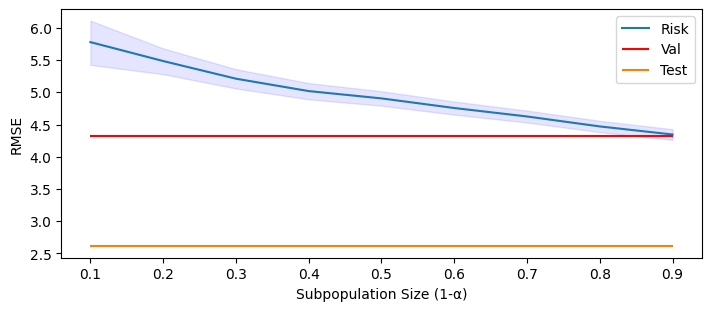

In [211]:
mn_log, lb_log, ub_log = calculate_worst_case_risk(err_val, X_val, immutable, mutable)
plot_risk(mn_log, lb_log, ub_log, err_test, '', err_val)

And then: Worst case risk on fake data vs loss on test set.

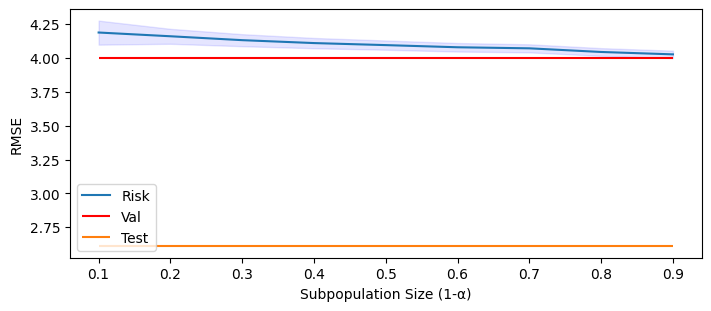

In [210]:
mn_log, lb_log, ub_log = calculate_worst_case_risk(err_fake, vae_generated, immutable, mutable)
plot_risk(mn_log, lb_log, ub_log, err_test, '', err_fake)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:36<00:00, 31.34s/it]


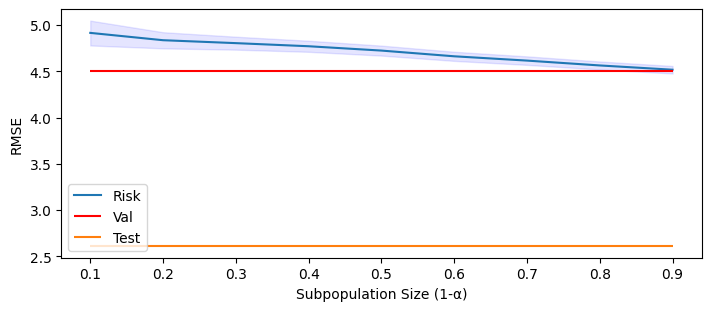

In [212]:
mn_log, lb_log, ub_log = calculate_worst_case_risk(err_fake_gan, gan_generated, immutable, mutable)
plot_risk(mn_log, lb_log, ub_log, err_test, '', err_fake_gan)

As we can see, we can get a narrower uncertainty interval for fake data.

This means that we can more precisely assess the robustness of the model using fake data.